# **Example AWARE | Use case 1**

**Author:**  
[Romain Sacchi](mailto:romain.sacchi@psi.ch)

This notebook presents an example to build an edges-based LCA using the AWARE method.

## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA](#sec_run_edges_lca)
5. [Export results](#sec_export_results)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import edges and set bw2 project

In [1]:
from edges import EdgeLCIA, get_available_methods
import bw2data, bw2io

17:09:41+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [2]:
bw2data.projects.set_current("ecoinvent-3.10.1-cutoff")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

In [3]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10.1-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()


classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()
    

Extracted 1 worksheets in 0.14 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.31 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 276.45it/s]


17:09:56+0200 [info     ] Vacuuming database            
Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU

In [4]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

In [5]:
get_available_methods()

[('AWARE 2.0', 'Country', 'all', 'yearly'),
 ('AWARE 2.0', 'Country', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'non', 'irri', 'yearly'),
 ('AWARE 2.0', 'Country', 'unspecified', 'yearly'),
 ('GeoPolRisk', 'elementary flows', '2024'),
 ('GeoPolRisk', 'paired', '2024'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater acidification', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, long term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater ecotoxicity, short term', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'damage'),
 ('ImpactWorld+ 2.1', 'Freshwater eutrophication', 'midpoint'),
 ('ImpactWorld+ 2.1', 'Land occupation, biodiversity', 'damage'),
 ('Im

In [6]:
method = ('AWARE 2.0', 'Country', 'all', 'yearly')
method

('AWARE 2.0', 'Country', 'all', 'yearly')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA

In [7]:
LCA = EdgeLCIA(
    demand={act: 1},
    method=method,
    use_distributions=True,
    iterations=10000
)
LCA.lci()

LCA.map_exchanges()
LCA.map_aggregate_locations()
LCA.map_dynamic_locations()
LCA.map_contained_locations()
LCA.map_remaining_locations_to_global()

No parameters or scenarios found in method file: C:\Users\hahnme_a\PycharmProjects\edges\edges\data\AWARE 2.0_Country_all_yearly.json
Mapping exchanges: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9960/9960 [02:07<00:00, 78.04it/s]


Processed edges: 3923
Handling static regions...


Processing static groups (pass 1): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.46it/s]
Processing static groups (pass 2): 0it [00:00, ?it/s]
Processing static groups (pass 1): 0it [00:00, ?it/s]
Processing static groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 6596
Handling dynamic regions...


IN-DD not found in regex
US-PR not found in regex
Processing dynamic groups (pass 1): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.75it/s]
Processing dynamic groups (pass 2): 0it [00:00, ?it/s]
Processing dynamic groups (pass 1): 0it [00:00, ?it/s]
Processing dynamic groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 8905
Handling contained locations...


Processing contained groups (pass 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 181.64it/s]
Processing contained groups (pass 2): 0it [00:00, ?it/s]
Processing contained groups (pass 1): 0it [00:00, ?it/s]
Processing contained groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 9043
Handling remaining exchanges...


Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 0it [00:00, ?it/s]
Processing global groups (pass 1): 0it [00:00, ?it/s]
Processing global groups (pass 2): 0it [00:00, ?it/s]


Processed edges: 9043


In [8]:
LCA.evaluate_cfs()

In [9]:
y = [x for x in LCA.cfs_mapping if x["consumer"]["location"] == "RER"][:1]

In [10]:
sum(y[0]["uncertainty"]["parameters"]["weights"])

1.0000000000000004

In [11]:
LCA.lcia()

In [12]:
print(LCA.score)

<COO: shape=(10000,), dtype=float64, nnz=10000, fill_value=0.0>


<a id="sec_export_results"></a>
# 5. Export results

In [13]:
df_table = LCA.generate_cf_table()

In [14]:
df_table.to_excel("AWARE_results.xlsx")

In [15]:
LCA.statistics()

+----------------------+--------------------------------------------+
|       Activity       | hydrogen production, gaseous, 30 bar, from |
|                      |    PEM electrolysis, from offshore wind    |
|                      |                electricity                 |
|     Method name      | ('AWARE 2.0', 'Country', 'all', 'yearly')  |
|         Unit         |           m3 deprived water-eq.            |
|      Data file       |        AWARE 2.0_Country_all_yearly        |
|    CFs in method     |                    9960                    |
|       CFs used       |                    5818                    |
|   Unique CFs used    |                    345                     |
|  Exc. characterized  |                    9043                    |
| Exc. uncharacterized |                   331853                   |
+----------------------+--------------------------------------------+


<a id="sec_plot_results"></a>
# 6. Plot results

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

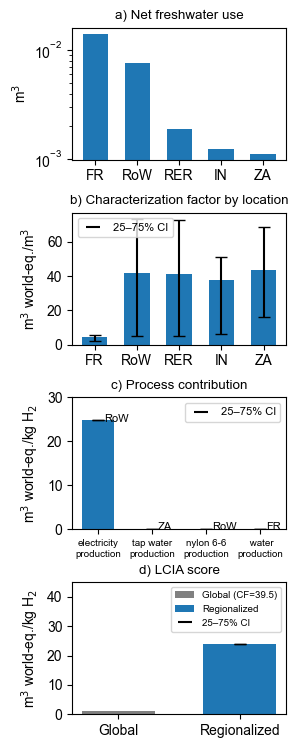

In [18]:
cutoff = 0.00

# Plotting
fig, axes = plt.subplots(4, 1, figsize=(3, 8))


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 8
})

# Legend for CI 25–75
errorbar_legend = Line2D(
    [0], [0],
    color='black',
    linestyle='none',
    marker='_',
    markersize=10,
    markeredgewidth=1.5,
    label='25–75% CI'
)

# remove rows for which "amount" is below the cutoff
m = df_table.loc[df_table["impact (mean)"] > 0, "impact (mean)"].max()
df = df_table[df_table["impact (mean)"].abs() > cutoff * m]

df_net = df.copy()
if "CF (mean)" in df_net.columns:  # Probabilistic case
    df_net.loc[df_net["CF (mean)"] < 0, "amount" ] *= -1
else:
    df_net.loc[df_net["CF"] < 0, "amount"] *= -1


d = df_net.groupby("consumer location").sum(numeric_only=True)
d = d[d["impact (mean)"] > 0] if "impact (mean)" in d.columns else d[d["impact"] > 0]
d = d.sort_values(by="amount", ascending=False).head(5)

d["amount"].plot(kind="bar", ax=axes[0], xlabel='', width=0.6)
axes[0].set_title("a) Net freshwater use")
axes[0].set_ylabel("m$^3$")
axes[0].set_xticks(range(len(d)))
axes[0].set_xticklabels(d.index, rotation=0)
axes[0].set_yscale('log')


# -------- 2. Average CF by location --------
# Add percentile-based error bars if available
# Filter down to the top 10
lower_percentile = "(25th)"
top_percentile = "(75th)"
d_top = df.copy()
d_top = d_top.loc[d_top["CF (mean)"]>0]
d_top = d_top.groupby("consumer location").mean(numeric_only=True)
#d_top = d_top.sort_values(by="amount", ascending=False)
d_top = d_top.loc[d.index]
x = d_top.index
y = d_top["CF (mean)"]

# Ensure CF percentiles exist
if f"CF {lower_percentile}" in d.columns and f"CF {top_percentile}" in d.columns:
    d_top.loc[d_top[f"CF {lower_percentile}"]>d_top["CF (mean)"], f"CF {lower_percentile}"] = d_top["CF (mean)"]
    d_top.loc[d_top[f"CF {top_percentile}"]<d_top["CF (mean)"], f"CF {top_percentile}"] = d_top["CF (mean)"]
    lower = y - d_top[f"CF {lower_percentile}"]
    upper = d_top[f"CF {top_percentile}"] - y
    cf_errors = np.array([lower.values, upper.values])
else:
    cf_errors = None

# Plot with error bars
axes[1].bar(x, y, yerr=cf_errors, capsize=4, width=0.6)
axes[1].set_title("b) Characterization factor by location")
axes[1].set_ylabel("m$^3$ world-eq./m$^3$")
axes[1].set_xticks(range(len(x)))
axes[1].set_xticks(range(len(x)))
axes[1].set_xticklabels(x, rotation=0)

axes[1].legend(handles=[errorbar_legend], loc='upper left', fontsize=8)
#axes[1].legend().remove()

# -------- 3. Grouped bar plot with error bars --------
df_ = df.copy()
df_["consumer name"] = df_["consumer name"].str.split(", ").str[0]
df_["label"] = df_["consumer name"] + " (" + df_["consumer location"] + ")"
df_.loc[df_["CF (mean)"]<0, f"impact {lower_percentile}"] = df.loc[df["CF (mean)"]<0, f"impact {top_percentile}"]
df_.loc[df_["CF (mean)"]<0, f"impact {top_percentile}"] = df.loc[df["CF (mean)"]<0, f"impact {lower_percentile}"]
# Compute mean impact and select top 4
top_df = df_[["label", "impact (mean)", f"impact {lower_percentile}", f"impact {top_percentile}"]].copy()
top_df = top_df.groupby("label", as_index=False).sum(numeric_only=True)
top_df = top_df.sort_values(by="impact (mean)", ascending=False).head(4)

# Compute asymmetric error bars
y = top_df["impact (mean)"]
err_lower = y - top_df[f"impact {lower_percentile}"]
err_upper = top_df[f"impact {top_percentile}"] - y
errors = np.array([err_lower.values, err_upper.values])
errors = np.clip(errors, 0, None)

df_global = df_table.copy()
df_global.loc[df_global["CF (mean)"]<0, "CF (mean)"] = -39.5
df_global.loc[df_global["CF (mean)"]>0, "CF (mean)"] = +39.5
df_global["impact (mean)"] = df_global["amount"] * df_global["CF (mean)"]
total_global = df_global["impact (mean)"].sum()
total_regionalized = df_table.copy()
total_regionalized.loc[total_regionalized["CF (mean)"]<0, f"impact {lower_percentile}"] = df_table.loc[df_table["CF (mean)"]<0, f"impact {top_percentile}"]
total_regionalized.loc[total_regionalized["CF (mean)"]<0, f"impact {top_percentile}"] = df_table.loc[df_table["CF (mean)"]<0, f"impact {lower_percentile}"]


# Plot
x = np.arange(len(top_df))
axes[2].bar(x, y, yerr=errors, capsize=4, width=0.6)
axes[2].set_xticks(x)
axes[2].set_xticklabels(top_df["label"].str.replace(" ", "\n"), rotation=0, ha="center")
axes[2].set_title("c) Process contribution")
axes[2].set_ylabel("m$^3$ world-eq./kg H$_2$")
axes[2].tick_params(axis="x", labelsize=8)
#axes[2].legend().remove()
axes[2].legend(handles=[errorbar_legend], loc='upper right', fontsize=8)

# Set x-axis ticks
axes[2].set_xticks(x)

# Extract country codes from the label (e.g., "Some process (FR)" → "FR")
labels = top_df["label"].str.replace(r" \(([^)]+)\)$", "", regex=True)
countries = top_df["label"].str.extract(r"\(([^)]+)\)$")[0]

# Set shortened labels (without country codes)
labels = [label.rsplit(" ", 1)[0] + "\n" + label.rsplit(" ", 1)[1] if " " in label else label
     for label in labels]
labels = [label.replace("deionized", "").replace("gravel and sand ", "") for label in labels]
axes[2].set_xticklabels(
    labels,
    rotation=0,
    ha="center",
    size=7
)
axes[2].set_ylim(0, 30)


# Annotate with country codes above bars
for xi, yi, code in zip(x, y, countries):
    axes[2].annotate(
        code,
        (xi + 0.1, yi + 0.03),  # Shift slightly to the right
        textcoords="offset points",
        xytext=(0.1, -1),
        ha='left',
        fontsize=8,
    )

# === Fourth plot (d) - Global vs Regionalized ===
global_mean = total_global
regional_mean = total_regionalized["impact (mean)"].sum()
regional_min = total_regionalized[f"impact {lower_percentile}"].sum()
regional_max = total_regionalized[f"impact {top_percentile}"].sum()

regional_error = [
    regional_mean - regional_min,
    regional_max - regional_mean
]

ax4 = axes[3]
ax4.bar(["Global"], [global_mean], color="gray", label="Global (CF=39.5)", width=.6)
# ax4.bar(
#     1,
#     total_regionalized["impact (mean)"].sum(),
#     yerr=[[total_regionalized["impact (mean)"].sum() - total_regionalized[f"impact {lower_percentile}"].sum()],
#           [total_regionalized[f"impact {top_percentile}"].sum() - total_regionalized["impact (mean)"].sum()]],
#     capsize=4,
#     width=.6,
#     color='#1f77b4',  # Matplotlib default blue
#     label='Regionalized'
# )
ax4.bar(
    1,
    total_regionalized["impact (mean)"].sum(),
    yerr=[[np.clip(total_regionalized["impact (mean)"].sum() - total_regionalized[f"impact {lower_percentile}"].sum(), 0, None)],
          [np.clip(total_regionalized[f"impact {top_percentile}"].sum() - total_regionalized["impact (mean)"].sum(), 0, None)]],
    capsize=4,
    width=.6,
    color='#1f77b4',
    label='Regionalized'
)

ax4.set_title("d) LCIA score")
ax4.set_ylabel("m$^3$ world-eq./kg H$_2$")
# ax4.set_ylim(0, max(global_mean, regional_max) * 1.2)
ax4.set_ylim(0, 45)
ax4.set_xticks([0, 1])
ax4.set_xticklabels(["Global", "Regionalized"])

# Append to existing legend
handles, labels = axes[3].get_legend_handles_labels()
handles.append(errorbar_legend)
labels.append('25–75% CI')
axes[3].legend(handles=handles, labels=labels, loc='upper right', fontsize=7)

# === Final layout tweaks ===
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig("figure_1.png", bbox_inches="tight", dpi=150)
plt.show()

In [19]:
total_regionalized[f"impact {lower_percentile}"].sum()

np.float64(49.09519318502931)

In [20]:
total_regionalized[f"impact {top_percentile}"].sum()

np.float64(4.933556649435923)

In [21]:
LCA.score.data.mean()

np.float64(24.060477257916943)

In [22]:
global_mean

np.float64(1.1739535970298722)